# Sevens Strategy


In [25]:
from datetime import datetime, timedelta
import logging
import pytz
import pandas as pd

from alpaca.data.timeframe import TimeFrame, TimeFrameUnit
import pandas as pd
from talib import ATR, EMA, RSI

from examples.data import (
    download_bars,
    separate_bars_by_symbol,
    split_multi_index_bars_train_test,
)

from bacta.backtester import EventBacktester, Order, Position
from bacta.utilities import dash
from bacta.utilities.logger import get_logger, set_log_level
logger = get_logger()
set_log_level(logging.DEBUG)

In [26]:
class EmaStrategy(EventBacktester):
    """
    Backtester that uses the Keltner Channel to make decisions.
    """

    def __init__(self, active_symbols, cash, **kwargs):
        super().__init__(active_symbols, cash, **kwargs)
        stretch = 1
        self.long_ma_period = 200 * stretch
        self.period_low = 7
        self.period_high = 7

        self.max_position_value = 700

    def precompute_step(self, bars: pd.DataFrame):
        """
        Preload the indicators for the backtest.
        """

        split_bars = separate_bars_by_symbol(bars)

        # seven period low
        self.lows = {
            symbol: split_bars[symbol].loc[:, "close"].rolling(window=self.period_low).mean()
            for symbol in self.active_symbols
        }

        # seven period high
        self.highs = {
            symbol: split_bars[symbol].loc[:, "close"].rolling(window=self.period_high).mean()
            for symbol in self.active_symbols
        }

        # long ma
        self.long_ma = {
            symbol: split_bars[symbol].loc[:, "close"].rolling(window=self.long_ma_period).mean()
            for symbol in self.active_symbols
        }

    def update_step(self, bars: pd.DataFrame, index: pd.Timestamp):
        """
        Update the state of the backtester.
        """
        split_bars = separate_bars_by_symbol(bars)
        # seven period low
        self.lows = {
            symbol: split_bars[symbol].loc[:, "close"].rolling(window=self.period_low).min()
            for symbol in self.active_symbols
        }

        # seven period high
        self.highs = {
            symbol: split_bars[symbol].loc[:, "close"].rolling(window=self.period_high).max()
            for symbol in self.active_symbols
        }

        # long ma
        self.long_ma = {
            symbol: split_bars[symbol].loc[:, "close"].rolling(window=self.long_ma_period).mean()
            for symbol in self.active_symbols
        }



    def generate_orders(self, bar: pd.DataFrame, index: pd.Timestamp) -> list[Order]:
        """
        Make a decision based on the prices.
        """
        close_prices = bar.loc[:, "close"]
        # short ema is 21, long ema is 200
        # rsi is 14
        # if rsi is > 75 and short ema is > long ema, then short
        # if rsi is < 25 and short ema is < long ema, then long
        orders = []

        for symbol in self.active_symbols:
            position_value = abs(self.get_position(symbol)*close_prices[symbol]) if self.get_position(symbol) != 0 else 0
            quantity = round(200 / close_prices[symbol], 4)
            current_close = close_prices[symbol]
            period_low = self.lows[symbol][index]
            period_high = self.highs[symbol][index]
            long_ma = self.long_ma[symbol][index]
            logger.info(f"current_close: {current_close}, period_low: {period_low}, period_high: {period_high}, long_ma: {long_ma}")
            # if current close is below long ma, then long
            if current_close < period_low and current_close > long_ma:
                orders.append(
                    Order(symbol, Position.LONG,
                          current_close, quantity)
                )
            # if current close is above period high, then short
            if current_close > period_high:
                orders.append(
                    Order(symbol, Position.SHORT,
                          current_close, quantity)
                )
            

        return orders


In [27]:
symbols = ["AAPL", "MSFT", "GOOG"]  

shift = - timedelta(days=1)
bars = download_bars(
    symbols,
    start_date=datetime(2025, 4, 1) - shift,
    end_date=datetime(2025, 7, 1) - shift,
    timeframe=TimeFrame(1, TimeFrameUnit.Hour)
)
# split the bars into train and test
train_bars, test_bars = split_multi_index_bars_train_test(
    bars, split_ratio=0.2)
    
# create the backtester
backtester = EmaStrategy(
    symbols,
    cash=2000,
    allow_short=True,
    allow_overdraft=False,
    min_cash_balance=200,
    min_trade_value=1,
    market_hours_only=True,
    transaction_cost=0.000,
    transaction_cost_type="percentage",
)

# preload the train bars
backtester.load_train_bars(train_bars)

# run_backtest the backtest
backtester.run_backtest(test_bars)

# plot the order and state history
print(dash("order history"))
print(backtester.get_history())
print(dash("state history"))
print(backtester.get_state_history())

[2025-08-17 18:31:54][DEBUG] Loading data/AAPLMSFTGOOG_2025-04-02_2025-07-02_1Hour.pkl
[2025-08-17 18:31:54][DEBUG] Initializing backtester with active symbols: ['AAPL', 'MSFT', 'GOOG'], cash: 2000, allow_short: True, allow_overdraft: False, min_cash_balance: 200, min_trade_value: 1, market_hours_only: True
[2025-08-17 18:31:54][INFO] Train bars have been previously loaded. Concatenating with test bars...
[2025-08-17 18:31:54][INFO] Running backtest over 6093 bars from 2025-04-20 07:00:00-04:00 to 2025-07-01 19:00:00-04:00...
[2025-08-17 18:31:55][INFO] current_close: 191.04, period_low: 191.04, period_high: 193.99, long_ma: 197.6489
[2025-08-17 18:31:55][INFO] current_close: 359.43, period_low: 359.43, period_high: 364.83, long_ma: 375.33075
[2025-08-17 18:31:55][INFO] current_close: 149.63, period_low: 149.03, period_high: 151.56, long_ma: 155.73845
[2025-08-17 18:31:55][INFO] current_close: 189.8, period_low: 189.8, period_high: 193.99, long_ma: 197.6155
[2025-08-17 18:31:55][INFO] 

- order history ----------------------------------------------------------------
Empty DataFrame
Columns: [symbol, position, price, quantity]
Index: []
- state history ----------------------------------------------------------------
                             cash  portfolio_value  AAPL  MSFT  GOOG
0                          2000.0           2000.0   0.0   0.0   0.0
2025-04-20 07:00:00-04:00  2000.0           2000.0   0.0   0.0   0.0
2025-04-20 08:00:00-04:00  2000.0           2000.0   0.0   0.0   0.0
2025-04-20 09:00:00-04:00  2000.0           2000.0   0.0   0.0   0.0
2025-04-20 10:00:00-04:00  2000.0           2000.0   0.0   0.0   0.0
...                           ...              ...   ...   ...   ...
2025-07-01 12:00:00-04:00  2000.0           2000.0   0.0   0.0   0.0
2025-07-01 13:00:00-04:00  2000.0           2000.0   0.0   0.0   0.0
2025-07-01 14:00:00-04:00  2000.0           2000.0   0.0   0.0   0.0
2025-07-01 15:00:00-04:00  2000.0           2000.0   0.0   0.0   0.0
2025-07-

In [28]:
# plot the performance
print(dash("performance"))
print(backtester.pretty_format_performance())

[2025-08-17 18:32:05][INFO] Auto-calculated periods per year: 8766 (avg time diff: 3600.0 seconds)


- performance ------------------------------------------------------------------
Backtest Performance:
- Return on Investment: 0.00%
- vs. Buy and Hold Return: 18.45%
- Sharpe Ratio: -inf
- Max Drawdown Percentage: 0.00%

- Start Portfolio Value: $2000.00
- End Portfolio Value: $2000.00
- Min Portfolio Value: $2000.00
- Max Portfolio Value: $2000.00
- Min Cash Balance: $2000.00
- Max Cash Balance: $2000.00
- Win Rate: 0.00%

- Number of Orders: 0
- Avg Orders per Day: 0.00
- Number of Winning Trades: 0
- Number of Losing Trades: 0
- Avg Trade Return: nan%
- Largest Win: nan% ($nan)
- Largest Loss: 0.00% ($nan)
- Max Consecutive Wins: nan
- Max Consecutive Losses: nan

- Trading Period Start: 2025-04-20 07:00:00-04:00
- Trading Period End: 2025-07-01 16:00:00-04:00
- Trading Period Length: 72 days 09:00:00
- Time in Market: 0.00%


[2025-08-17 18:32:05][INFO] Auto-calculated periods per year: 8766 (avg time diff: 3600.0 seconds)


plotting...


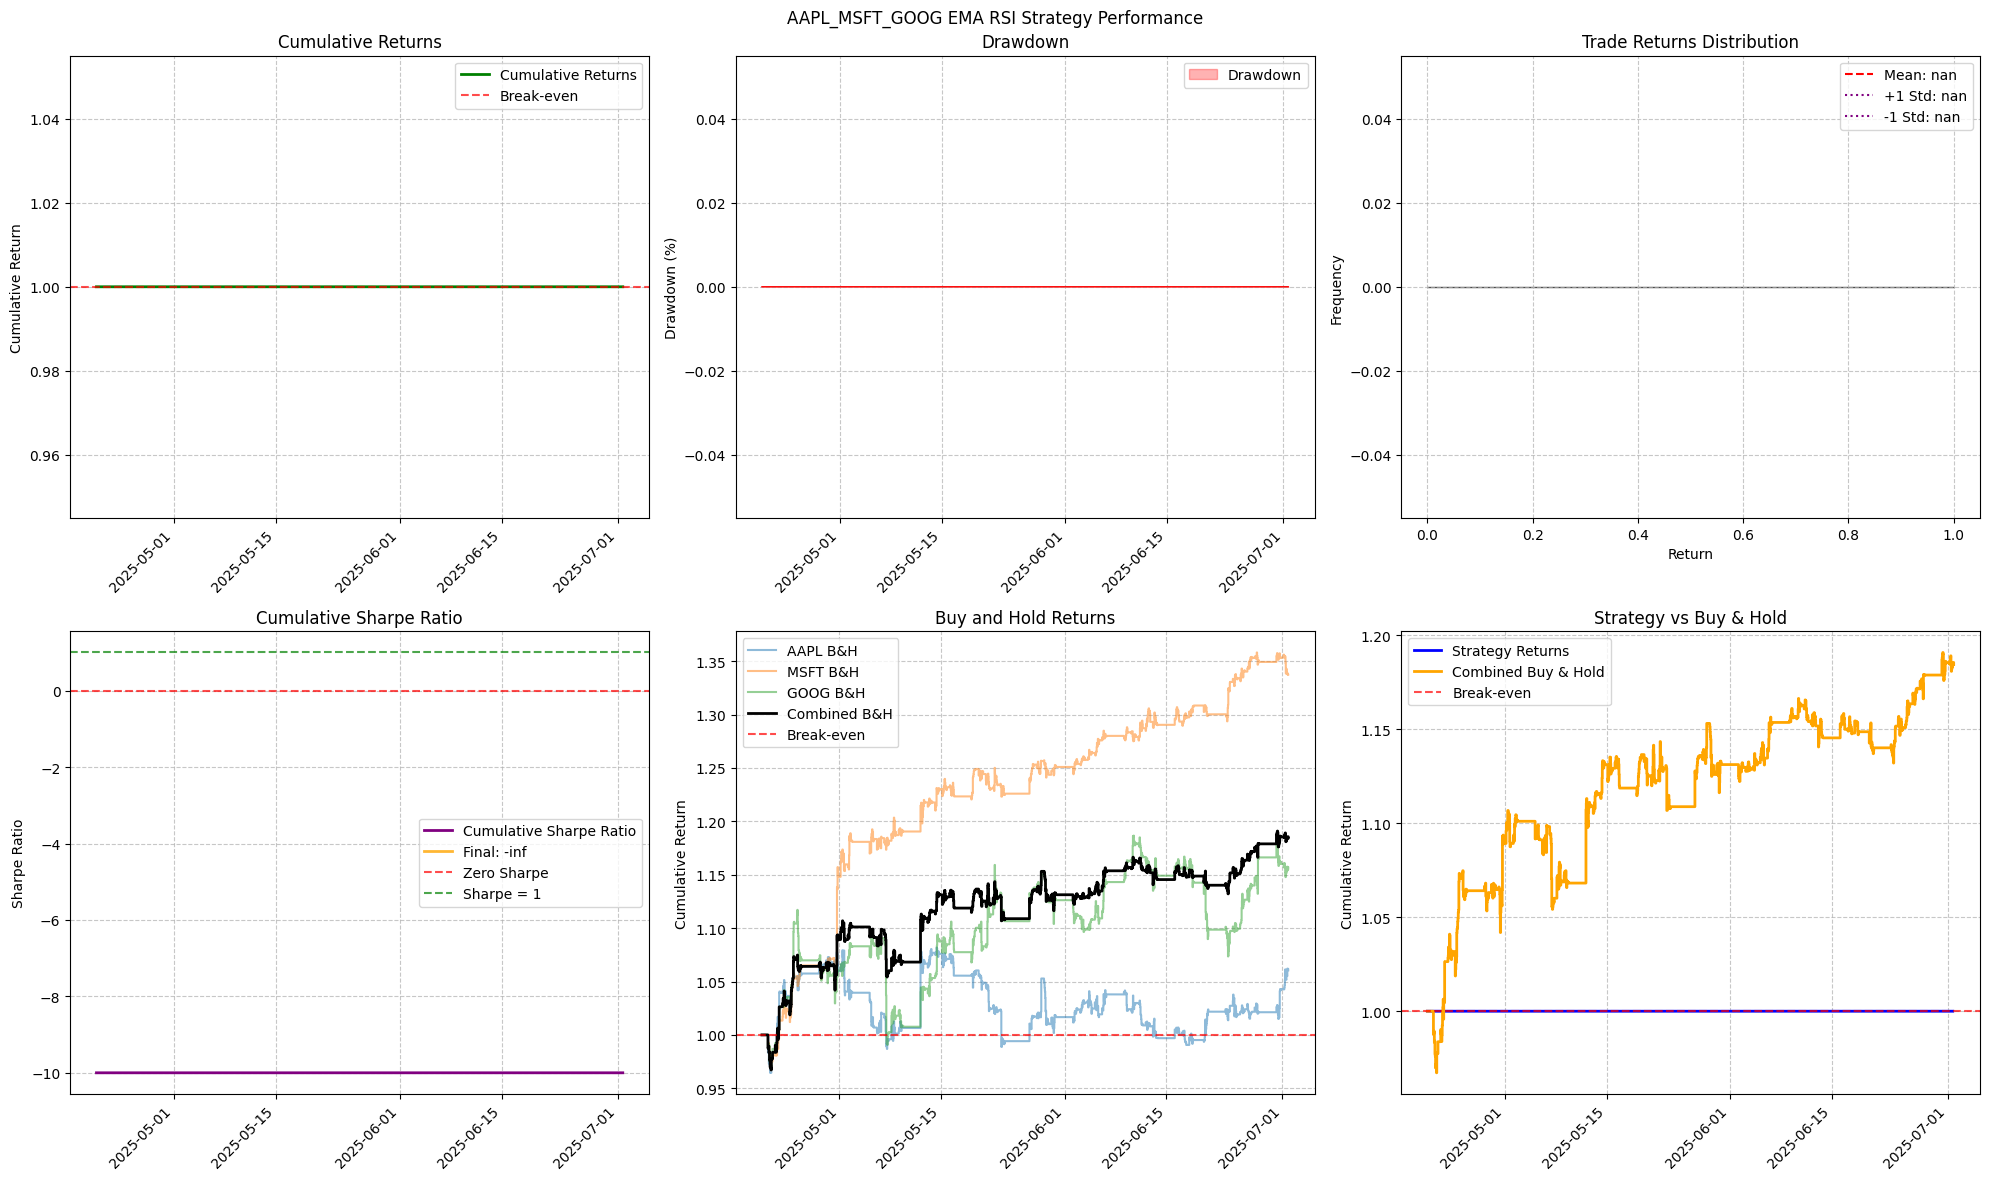

In [29]:
# Plot the results
print("plotting...")
backtester.plot_performance_analysis(
    title="_".join(symbols) + " EMA RSI Strategy Performance", show_plot=False)

In [30]:
backtester.plot_trade_history(title="_".join(
    symbols) + " EMA RSI Strategy Trades", show_plot=False)

[2025-08-17 18:32:07][WARNING] No order history available for plotting trade history


[2025-08-17 18:32:07][INFO] Auto-calculated periods per year: 8766 (avg time diff: 3600.0 seconds)


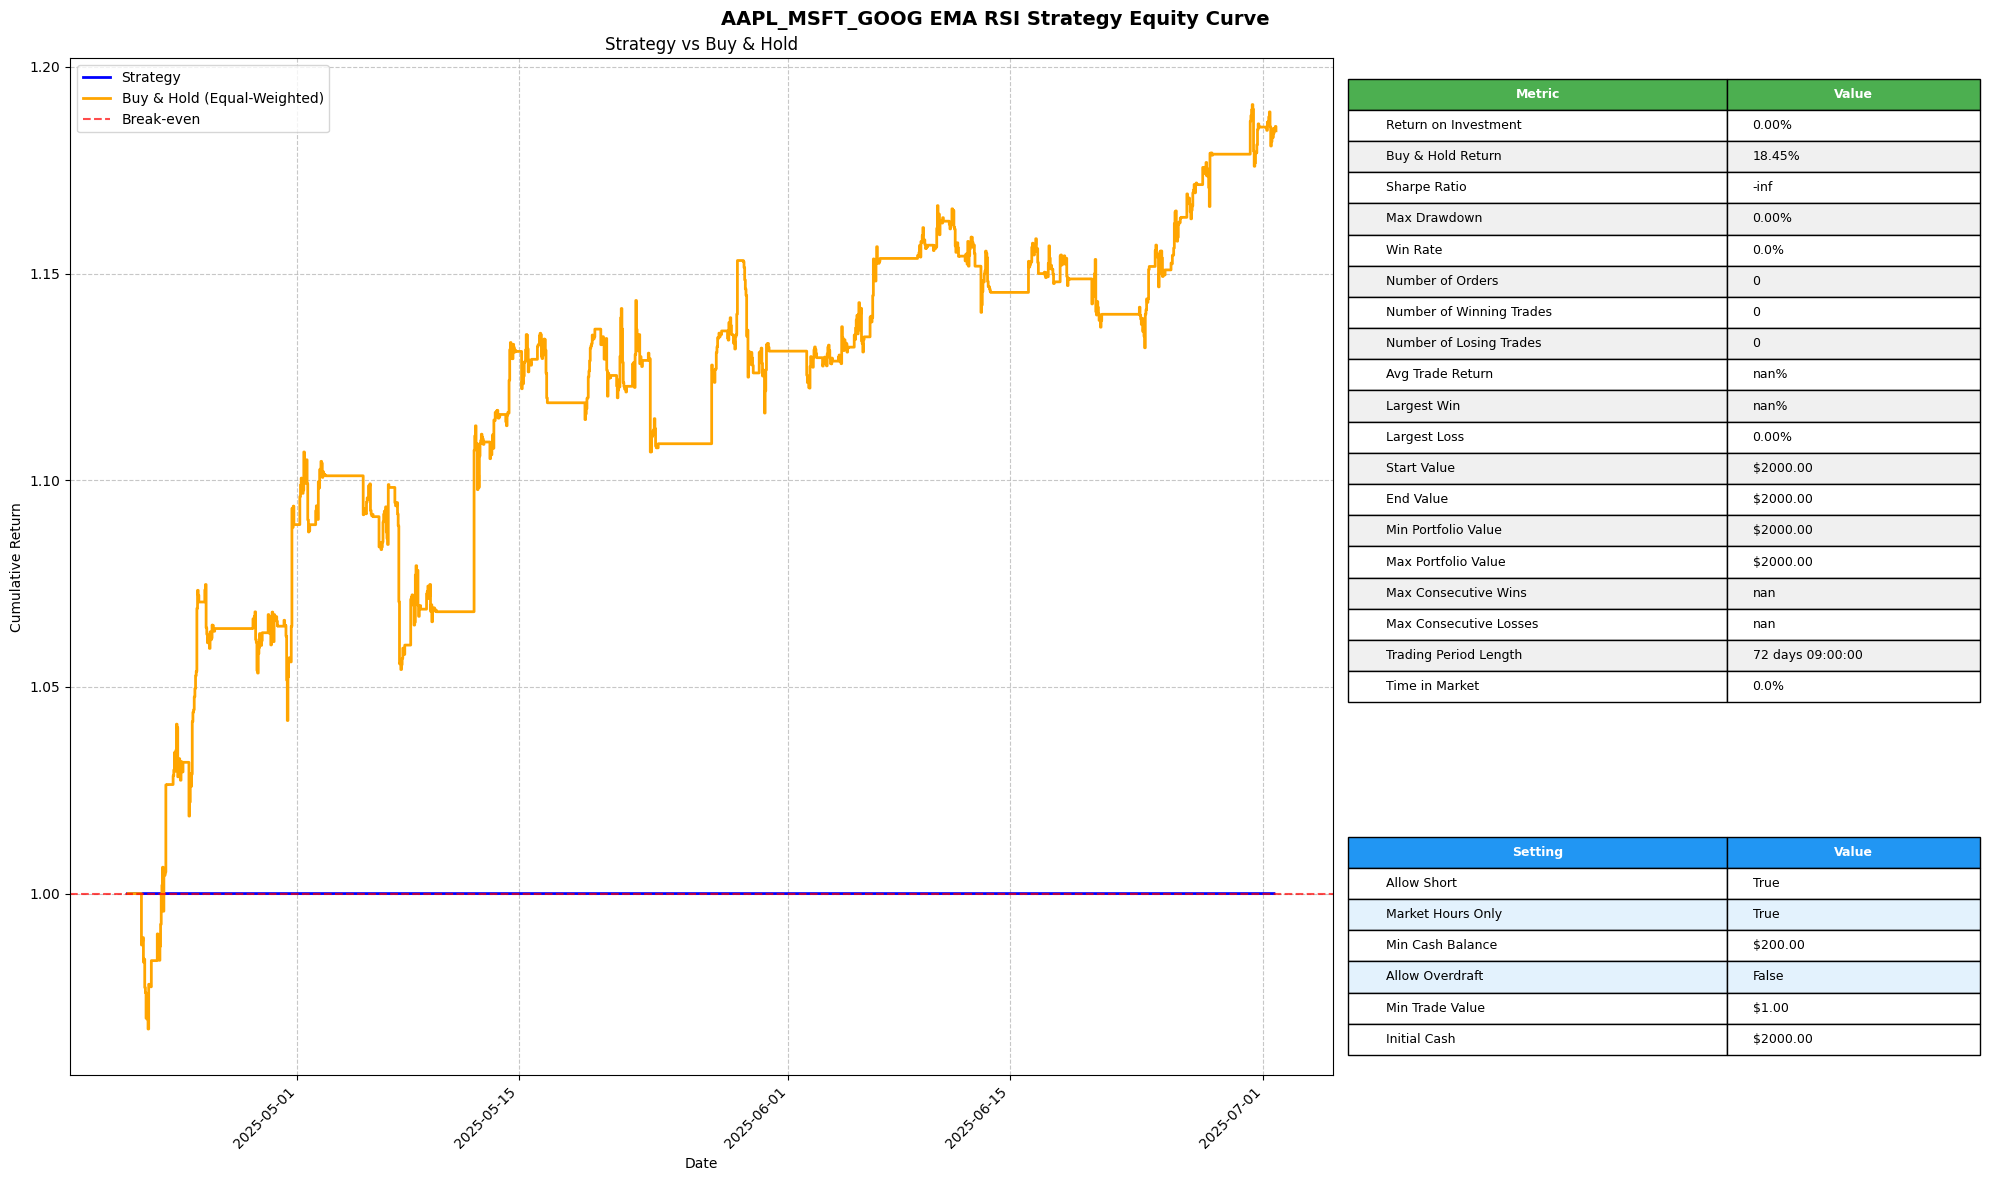

In [31]:
backtester.plot_equity_curve(
    title="_".join(symbols) + " EMA RSI Strategy Equity Curve", show_plot=False
)